# Use SageMaker Pipelines to Run Your Jobs Locally

This notebook demonstrates how to orchestrate SageMaker jobs locally using SageMaker Pipelines. 

Using a `LocalPipelineSession` object, you can now run your pipelines on your local machine before running them in the cloud. 

The `LocalPipelineSession` object is used while defining each pipeline step and when defining the complete Pipeline object. To run this pipeline in the cloud, each step along with the Pipeline object must be redefined using `PipelineSession`.

**Note**: This notebook will not run in SageMaker Studio. You can run this on SageMaker Classic Notebook instances OR your local IDE.

## SageMaker Pipelines Local Mode

SageMaker Pipelines Local Mode supports the following activities, which are demonstrated in this notebook:

* ProcessingStep
* TrainingStep
* ConditionStep
* ModelStep
* TransformStep
* FailStep

## Dataset

The dataset you use is the [UCI Machine Learning Abalone Dataset](https://archive.ics.uci.edu/ml/datasets/abalone) [1].  The aim for this task is to determine the age of an abalone snail from its physical measurements. At the core, this is a regression problem.

The dataset contains several features: length (the longest shell measurement), diameter (the diameter perpendicular to length), height (the height with meat in the shell), whole_weight (the weight of whole abalone), shucked_weight (the weight of meat), viscera_weight (the gut weight after bleeding), shell_weight (the weight after being dried), sex ('M', 'F', 'I' where 'I' is Infant), and rings (integer).

The number of rings turns out to be a good approximation for age (age is rings + 1.5). However, to obtain this number requires cutting the shell through the cone, staining the section, and counting the number of rings through a microscope, which is a time-consuming task. However, the other physical measurements are easier to determine. You use the dataset to build a predictive model of the variable rings through these other physical measurements.

Before you upload the data to an S3 bucket, install the SageMaker Python SDK and gather some constants you can use later in this notebook.

> [1] Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.

#### Install the latest version of the SageMaker Python SDK. 

In [ ]:
!pip install 'sagemaker' --upgrade

In [ ]:
import sys

import boto3
import sagemaker
from sagemaker.workflow.pipeline_context import LocalPipelineSession

# Create a `LocalPipelineSession` object so that each pipeline step will run locally
# To run this pipeline in the cloud, you must change `LocalPipelineSession()` to `PipelineSession()`
local_pipeline_session = LocalPipelineSession()

region = local_pipeline_session.boto_region_name

default_bucket = local_pipeline_session.default_bucket()
prefix = "sagemaker-pipelines-local-mode-example"

role = None  # Role is set below

### Please Note: Provide SageMaker Execution Role ARN if not running on SageMaker Notebook environment



<div class="alert alert-info"> 💡 <strong> Set Execution Role for Permissions </strong>
If you are running this notebook from a local machine, as opposed to within the SageMaker Jupyter environment, you will need to add the code below, after filling in the name for a valid SageMaker Execution Role. <br/>
    <strong><a style="color: #0397a7" href="https://console.aws.amazon.com/iam/home#/roles">
    <u>Click here to lookup IAM SageMaker Execution Roles</u></a> 
    The except block below will lookup the ARN from the role name.
</strong>
</div>

In [ ]:
# try:
#    role = sagemaker.get_execution_role()
# except ValueError:
#    iam = boto3.client('iam')
#    role = iam.get_role(RoleName='<Fill-In-Name-Of-AmazonSageMaker-ExecutionRole>')['Role']['Arn']

In [ ]:
if role is None:
    role = sagemaker.get_execution_role()

print(role)

Now, upload the data into the default bucket. You can select our own data set for the `input_data_uri` as is appropriate.

In [ ]:
!mkdir -p data

In [ ]:
# Pull the dataset from SageMaker's public S3 bucket and upload it to your own S3 bucket

local_path = "data/abalone-dataset.csv"

s3 = boto3.resource("s3")
s3.Bucket(f"sagemaker-sample-files").download_file(
    "datasets/tabular/uci_abalone/abalone.csv", local_path
)

base_uri = f"s3://{default_bucket}/{prefix}/abalone-data-set"
input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path,
    desired_s3_uri=base_uri,
)
print(input_data_uri)

In [ ]:
from sagemaker.workflow.parameters import ParameterString, ParameterFloat

processing_instance_count = 1
training_instance_count = 1
transform_instance_count = 1
instance_type = "ml.m5.xlarge"

input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri,
)

mse_threshold = ParameterFloat(name="MseThreshold", default_value=7.0)

## Define a Processing Step for Feature Engineering

First, develop a preprocessing script that is specified in the Processing step.

This notebook cell writes a file `preprocessing_abalone.py`, which contains the preprocessing script. You can update the script, and rerun this cell to overwrite. The preprocessing script uses `scikit-learn` to do the following:

* Fill in missing sex category data and encode it so that it is suitable for training.
* Scale and normalize all numerical fields, aside from sex and rings numerical data.
* Split the data into training, validation, and test datasets.

The Processing step executes the script on the input data. The Training step uses the preprocessed training features and labels to train a model. The Evaluation step uses the trained model and preprocessed test features and labels to evaluate the model.

In [ ]:
!mkdir -p code

In [ ]:
%%writefile code/preprocessing.py
import argparse
import os
import requests
import tempfile

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Since we get a headerless CSV file, we specify the column names here.
feature_columns_names = [
    "sex",
    "length",
    "diameter",
    "height",
    "whole_weight",
    "shucked_weight",
    "viscera_weight",
    "shell_weight",
]
label_column = "rings"

feature_columns_dtype = {
    "sex": str,
    "length": np.float64,
    "diameter": np.float64,
    "height": np.float64,
    "whole_weight": np.float64,
    "shucked_weight": np.float64,
    "viscera_weight": np.float64,
    "shell_weight": np.float64,
}
label_column_dtype = {"rings": np.float64}


def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z


if __name__ == "__main__":
    base_dir = "/opt/ml/processing"

    df = pd.read_csv(
        f"{base_dir}/input/abalone-dataset.csv",
        header=None,
        names=feature_columns_names + [label_column],
        dtype=merge_two_dicts(feature_columns_dtype, label_column_dtype),
    )
    numeric_features = list(feature_columns_names)
    numeric_features.remove("sex")
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_features = ["sex"]
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    y = df.pop("rings")
    X_pre = preprocess.fit_transform(df)
    y_pre = y.to_numpy().reshape(len(y), 1)

    X = np.concatenate((y_pre, X_pre), axis=1)

    np.random.shuffle(X)
    train, validation, test = np.split(X, [int(0.7 * len(X)), int(0.85 * len(X))])

    pd.DataFrame(train).to_csv(f"{base_dir}/train/train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        f"{base_dir}/validation/validation.csv", header=False, index=False
    )
    pd.DataFrame(test).to_csv(f"{base_dir}/test/test.csv", header=False, index=False)

Next, create an instance of a `SKLearnProcessor` processor and use that in our `ProcessingStep`.

In [ ]:
from sagemaker.sklearn.processing import SKLearnProcessor

framework_version = "1.0-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type=instance_type,
    instance_count=processing_instance_count,
    base_job_name="sklearn-abalone-process",
    role=role,
    sagemaker_session=local_pipeline_session,
)

Finally, we take the output of the processor's `run` method and pass that as arguments to the `ProcessingStep`. By passing the `local_pipeline_session` to the `sagemaker_session`, calling `.run()` does not launch the processing job, it returns the arguments needed to run the job as a step in the pipeline.

Note the `"train_data"` and `"test_data"` named channels specified in the output configuration for the processing job. Step `Properties` can be used in subsequent steps and resolve to their runtime values at execution. Specifically, this usage is called out when you define the training step.

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
    ],
    code="code/preprocessing.py",
)

step_process = ProcessingStep(name="AbaloneProcess", step_args=processor_args)

In [ ]:
%%writefile code/abalone.py

import argparse
import json
import logging
import os
import pathlib
import pickle as pkl
import tarfile


import numpy as np
import pandas as pd
import xgboost as xgb

logging.basicConfig(level=logging.INFO)

TRAIN_VALIDATION_FRACTION = 0.2
RANDOM_STATE_SAMPLING = 200

logging.basicConfig(level=logging.INFO)


def prepare_data(train_dir, validation_dir):
    """Read data from train and validation channel, and return predicting features and target variables.

    Args:
        data_dir (str): directory which saves the training data.

    Returns:
        Tuple of training features, training target, validation features, validation target.
    """
    df_train = pd.read_csv(
        os.path.join(train_dir, "train.csv"),
        header=None,
    )
    df_train = df_train.iloc[np.random.permutation(len(df_train))]
    df_train.columns = ["target"] + [f"feature_{x}" for x in range(df_train.shape[1] - 1)]

    try:
        df_validation = pd.read_csv(
            os.path.join(validation_dir, "validation.csv"),
            header=None,
        )
        df_validation.columns = ["target"] + [
            f"feature_{x}" for x in range(df_validation.shape[1] - 1)
        ]

    except FileNotFoundError:  # when validation data is not available in the directory
        logging.info(
            f"Validation data is not found. {TRAIN_VALIDATION_FRACTION * 100}% of training data is "
            f"randomly selected as validation data. The seed for random sampling is {RANDOM_STATE_SAMPLING}."
        )
        df_validation = df_train.sample(
            frac=TRAIN_VALIDATION_FRACTION,
            random_state=RANDOM_STATE_SAMPLING,
        )
        df_train.drop(df_validation.index, inplace=True)
        df_validation.reset_index(drop=True, inplace=True)
        df_train.reset_index(drop=True, inplace=True)

    X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, :1]
    X_val, y_val = df_validation.iloc[:, 1:], df_validation.iloc[:, :1]

    return X_train.values, y_train.values, X_val.values, y_val.values


def main():
    """Run training."""
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--max_depth",
        type=int,
    )
    parser.add_argument("--eta", type=float)
    parser.add_argument("--gamma", type=int)
    parser.add_argument("--min_child_weight", type=int)
    parser.add_argument("--subsample", type=float)
    parser.add_argument("--verbosity", type=int)
    parser.add_argument("--objective", type=str)
    parser.add_argument("--num_round", type=int)
    parser.add_argument("--tree_method", type=str, default="auto")
    parser.add_argument("--predictor", type=str, default="auto")
    parser.add_argument("--learning_rate", type=str, default="auto")
    parser.add_argument("--output_data_dir", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--validation", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    parser.add_argument("--sm_hosts", type=str, default=os.environ.get("SM_HOSTS"))
    parser.add_argument("--sm_current_host", type=str, default=os.environ.get("SM_CURRENT_HOST"))

    args, _ = parser.parse_known_args()

    X_train, y_train, X_val, y_val = prepare_data(args.train, args.validation)

    # create dataset for lightgbm
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dval = xgb.DMatrix(data=X_val, label=y_val)
    watchlist = [(dtrain, "train"), (dval, "validation")]

    # specify your configurations as a dict
    params = {
        "booster": "gbtree",
        "objective": args.objective,
        "learning_rate": args.learning_rate,
        "gamma": args.gamma,
        "min_child_weight": args.min_child_weight,
        "max_depth": args.max_depth,
        "subsample": args.subsample,
        "colsample_bytree": 1,
        "reg_lambda": 1,
        "reg_alpha": 0,
        "eval_metric": "rmse",
    }

    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=args.num_round,
        evals=watchlist,
        xgb_model=None,
    )

    model_location = args.model_dir + "/xgboost-model"
    pkl.dump(bst, open(model_location, "wb"))
    logging.info("Stored trained model at {}".format(model_location))


if __name__ == "__main__":
    main()

In [ ]:
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput

model_path = f"s3://{default_bucket}/{prefix}/model"
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.5-1",
    py_version="py3",
    instance_type=instance_type,
)

xgb_train = Estimator(
    image_uri=image_uri,
    entry_point="code/abalone.py",
    instance_type=instance_type,
    instance_count=training_instance_count,
    output_path=model_path,
    role=role,
    sagemaker_session=local_pipeline_session,
)

xgb_train.set_hyperparameters(
    objective="reg:squarederror",
    learning_rate=0.01,
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
)

train_args = xgb_train.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "validation"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)

Finally, we use the output of the estimator's `.fit()` method as arguments to the `TrainingStep`. By passing the `local_pipeline_session` to the `sagemaker_session`, calling `.fit()` does not launch the training job, it returns the arguments needed to run the job as a step in the pipeline.

Pass in the `S3Uri` of the `"train_data"` output channel to the `.fit()` method. Also, use the other `"test_data"` output channel for model evaluation in the pipeline. The `properties` attribute of a Pipeline step matches the object model of the corresponding response of a describe call. These properties can be referenced as placeholder values and are resolved at runtime. For example, the `ProcessingStep` `properties` attribute matches the object model of the [DescribeProcessingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeProcessingJob.html) response object.

In [ ]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

step_train = TrainingStep(
    name="AbaloneTrain",
    step_args=train_args,
)

## Define a Model Evaluation Step to Evaluate the Trained Model

First, develop an evaluation script that is specified in a Processing step that performs the model evaluation.

After pipeline execution, you can examine the resulting `evaluation.json` for analysis.

The evaluation script uses `xgboost` to do the following:

* Load the model.
* Read the test data.
* Issue predictions against the test data.
* Build a classification report, including accuracy and ROC curve.
* Save the evaluation report to the evaluation directory.

In [ ]:
%%writefile code/evaluation.py
import json
import pathlib
import pickle
import tarfile

import joblib
import numpy as np
import pandas as pd
import xgboost
import math

from sklearn.metrics import mean_squared_error

if __name__ == "__main__":
    model_path = f"/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")

    model = pickle.load(open("xgboost-model", "rb"))

    test_path = "/opt/ml/processing/test/test.csv"
    df = pd.read_csv(test_path, header=None)
    df.columns = ["target"] + [f"feature_{x}" for x in range(df.shape[1] - 1)]

    y_test = df.iloc[:, 0].to_numpy()
    df.drop(df.columns[0], axis=1, inplace=True)

    X_test = xgboost.DMatrix(df.values)

    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    std = np.std(y_test - predictions)
    report_dict = {
        "regression_metrics": {
            "mse": {"value": math.sqrt(mse), "standard_deviation": std},
        },
    }

    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))

Next, create an instance of a `ScriptProcessor` processor and use it in the `ProcessingStep`.

In [ ]:
from sagemaker.processing import ScriptProcessor

script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type=instance_type,
    instance_count=processing_instance_count,
    base_job_name="script-abalone-eval",
    role=role,
    sagemaker_session=local_pipeline_session,
)

eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="code/evaluation.py",
)

Use the processor's arguments returned by `.run()` to construct a `ProcessingStep`, along with the input and output channels and the code that will be executed when the pipeline invokes pipeline execution. 

Specifically, the `S3ModelArtifacts` from the `step_train` `properties` and the `S3Uri` of the `"test_data"` output channel of the `step_process` `properties` are passed as inputs. The `TrainingStep` and `ProcessingStep` `properties` attribute matches the object model of the [DescribeTrainingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeTrainingJob.html) and [DescribeProcessingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeProcessingJob.html) response objects, respectively.

In [ ]:
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)
step_eval = ProcessingStep(
    name="AbaloneEval",
    step_args=eval_args,
    property_files=[evaluation_report],
)

## Define a Create Model Step to Create a Model

In order to perform batch transformation using the example model, create a SageMaker model. 

Specifically, pass in the `S3ModelArtifacts` from the `TrainingStep`, `step_train` properties. The `TrainingStep` `properties` attribute matches the object model of the [DescribeTrainingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeTrainingJob.html) response object.

We provide a custom inference script that defines the logic for the batch transform job

In [ ]:
%%writefile code/inference.py

import json
import os
import pickle as pkl

import numpy as np
import pandas as pd
import sagemaker_xgboost_container.encoder as xgb_encoders
import xgboost as xgb
import io
import logging

logging.basicConfig(level=logging.INFO)


def model_fn(model_dir):
    """
    Deserialize and return fitted model.
    """
    model_file = "xgboost-model"
    booster = pkl.load(open(os.path.join(model_dir, model_file), "rb"))
    return booster


def transform_fn(model, request_body, request_content_type, accept):
    """ """
    if request_content_type == "text/libsvm":
        input_data = xgb_encoders.libsvm_to_dmatrix(request_body)
    if request_content_type == "text/csv":
        df = pd.read_csv(io.StringIO(request_body.strip("\n")), header=None)
        df.drop(0, axis=1, inplace=True)
        input_data = xgb.DMatrix(data=df)

    else:
        raise ValueError("Content type {} is not supported.".format(request_content_type))

    prediction = model.predict(input_data)
    feature_contribs = model.predict(input_data, pred_contribs=True, validate_features=False)
    output = np.hstack((prediction[:, np.newaxis], feature_contribs))

    logging.info("Successfully completed transform job!")

    return ",".join(str(x) for x in output[0])

In [ ]:
from sagemaker.model import Model

model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    source_dir="code",
    entry_point="inference.py",
    role=role,
    sagemaker_session=local_pipeline_session,
)

Define the `ModelStep` by providing the return values from `model.create()` as the step arguments. 

In [ ]:
from sagemaker.workflow.model_step import ModelStep

step_create_model = ModelStep(
    name="AbaloneCreateModel", step_args=model.create(instance_type=instance_type)
)

## Define a Transform Step to Perform Batch Transformation

Now that a model instance is defined, create a `Transformer` instance with the appropriate model type, compute instance type, and desired output S3 URI.

Specifically, pass in the `ModelName` from the `CreateModelStep`, `step_create_model` properties. The `CreateModelStep` `properties` attribute matches the object model of the [DescribeModel](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeModel.html) response object.

In [ ]:
from sagemaker.transformer import Transformer


transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type=instance_type,
    instance_count=transform_instance_count,
    output_path=f"s3://{default_bucket}/{prefix}/transform",
    sagemaker_session=local_pipeline_session,
)

Pass in the transformer instance and the `TransformInput` with the `batch_data` pipeline parameter defined earlier.

In [ ]:
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep
from sagemaker.workflow.functions import Join

transform_data = Join(
    on="/",
    values=[
        step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
        "test.csv",
    ],
)

transform_args = transformer.transform(transform_data, content_type="text/csv")

step_transform = TransformStep(name="AbaloneTransform", step_args=transform_args)

In [ ]:
from sagemaker.workflow.fail_step import FailStep

step_fail = FailStep(
    name="AbaloneMSEFail",
    error_message=Join(on=" ", values=["Execution failed due to MSE >", mse_threshold]),
)

## Define a Condition Step to Check Accuracy and Conditionally Create a Model and Run a Batch Transformation Or Terminate the Execution in Failed State

In this step, the model is registered only if the accuracy of the model, as determined by the evaluation step `step_eval`, exceeded a specified value. Otherwise, the pipeline execution fails and terminates. A `ConditionStep` enables pipelines to support conditional execution in the pipeline DAG based on the conditions of the step properties.

In the following section, you:

* Define a `ConditionLessThanOrEqualTo` on the accuracy value found in the output of the evaluation step, `step_eval`.
* Use the condition in the list of conditions in a `ConditionStep`.
* Pass the `CreateModelStep` and `TransformStep` steps into the `if_steps` of the `ConditionStep`, which are only executed if the condition evaluates to `True`.
* Pass the `FailStep` step into the `else_steps`of the `ConditionStep`, which is only executed if the condition evaluates to `False`.

In [ ]:
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet

cond_lte = ConditionLessThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="regression_metrics.mse.value",
    ),
    right=mse_threshold,
)

step_cond = ConditionStep(
    name="AbaloneMSECond",
    conditions=[cond_lte],
    if_steps=[step_create_model, step_transform],
    else_steps=[step_fail],
)

## Define a Pipeline using `LocalPipelineSession`

In this section, combine the steps into a Pipeline so it can be executed. We provide a `LocalPipelineSession` object to the `Pipeline` so that when executed, all the steps in the pipeline will run locally on the  machine. By switching the `LocalPipelineSession` to a `sagemaker.session.Session` object, you can switch the execution to run in the cloud on SageMaker instances.

In [ ]:
from sagemaker.workflow.pipeline import Pipeline

pipeline_name = f"LocalModelPipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        input_data,
        mse_threshold,
    ],
    steps=[step_process, step_train, step_eval, step_cond],
    sagemaker_session=local_pipeline_session,
)

### (Optional) Examining the pipeline definition

The JSON of the pipeline definition can be examined to confirm the pipeline is well-defined and the parameters and step properties resolve correctly.

In [ ]:
import json

definition = json.loads(pipeline.definition())
definition

## Submit the pipeline to SageMaker and start execution

Submit the pipeline definition to the Pipeline service. The Pipeline service uses the role that is passed in to create all the jobs defined in the steps.

In [ ]:
pipeline.upsert(role_arn=role)

Start the pipeline and accept all the default parameters.

In [ ]:
execution = pipeline.start()

In [ ]:
steps = execution.list_steps()
steps

## Get the step outputs

In [ ]:
# Get output files from processing job

processing_job_name = steps["PipelineExecutionSteps"][0]["Metadata"]["ProcessingJob"]["Arn"]
outputs = local_pipeline_session.sagemaker_client.describe_processing_job(
    ProcessingJobName=processing_job_name
)["ProcessingOutputConfig"]["Outputs"]
for key in outputs:
    print(outputs[key]["S3Output"]["S3Uri"])

In [ ]:
# Get output from training job

training_job_name = steps["PipelineExecutionSteps"][1]["Metadata"]["TrainingJob"]["Arn"]
outputs = local_pipeline_session.sagemaker_client.describe_training_job(
    TrainingJobName=training_job_name
)
print("Model location : ", outputs["ModelArtifacts"]["S3ModelArtifacts"])

In [ ]:
# Get output from model evaluation step (processing job)

processing_job_name = steps["PipelineExecutionSteps"][2]["Metadata"]["ProcessingJob"]["Arn"]
outputs = local_pipeline_session.sagemaker_client.describe_processing_job(
    ProcessingJobName=processing_job_name
)["ProcessingOutputConfig"]["Outputs"]
for key in outputs:
    print(outputs[key]["S3Output"]["S3Uri"])

In [ ]:
# Get output of ModelStep
import json

model_name = steps["PipelineExecutionSteps"][-1]["Metadata"]["Model"]["Arn"]
outputs = local_pipeline_session.sagemaker_client.describe_model(ModelName=model_name)
print(outputs)

In [ ]:
# Get output from the TransformStep

transform_job_name = steps["PipelineExecutionSteps"][4]["Metadata"]["TransformJob"]["Arn"]
outputs = local_pipeline_session.sagemaker_client.describe_transform_job(
    TransformJobName=transform_job_name
)
print(outputs)

## Transition to running pipeline as SageMaker Managed Pipeline

We will now use a non-local PipelineSession object to re-run the Pipeline steps via SageMaker as a managed service. This will run all pipeline steps as SageMaker-managed processes. This will also allow us to view and track the results directly in the SageMaker Studio UI.

In [ ]:
from sagemaker.workflow.pipeline_context import PipelineSession

pipeline_session = PipelineSession()

In [ ]:
# Recreate the SKLearnProcessor with non-local session

framework_version = "1.0-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type=instance_type,
    instance_count=processing_instance_count,
    base_job_name="sklearn-abalone-process",
    role=role,
    sagemaker_session=pipeline_session,  # use non-local session
)

processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
    ],
    code="code/preprocessing.py",
)

step_process = ProcessingStep(name="AbaloneProcess", step_args=processor_args)

In [ ]:
print(f"image_uri: {image_uri}")
print(f"model_path: {model_path}")

In [ ]:
# Recreate the Estimator instance with non-local session

xgb_train = Estimator(
    image_uri=image_uri,
    entry_point="code/abalone.py",
    instance_type=instance_type,
    instance_count=training_instance_count,
    output_path=model_path,
    role=role,
    sagemaker_session=pipeline_session,  # use non-local session
)

xgb_train.set_hyperparameters(
    objective="reg:squarederror",
    learning_rate=0.01,
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
)

train_args = xgb_train.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "validation"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)

step_train = TrainingStep(
    name="AbaloneTrain",
    step_args=train_args,
)

In [ ]:
# Recreate the Script Processor instance with non-local session

script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type=instance_type,
    instance_count=processing_instance_count,
    base_job_name="script-abalone-eval",
    role=role,
    sagemaker_session=pipeline_session,  # use non-local session
)

eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="code/evaluation.py",
)

evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)

step_eval = ProcessingStep(
    name="AbaloneEval",
    step_args=eval_args,
    property_files=[evaluation_report],
)

In [ ]:
# Recreate the Model instance with non-local session

model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    source_dir="code",
    entry_point="inference.py",
    role=role,
    sagemaker_session=pipeline_session,  # use non-local session
)

step_create_model = ModelStep(
    name="AbaloneCreateModel", step_args=model.create(instance_type=instance_type)
)

In [ ]:
# Recreate the Transformer instance with non-local session

transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type=instance_type,
    instance_count=transform_instance_count,
    output_path=f"s3://{default_bucket}/{prefix}/transform",
    sagemaker_session=pipeline_session,  # use non-local session
)

transform_data = Join(
    on="/",
    values=[
        step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
        "test.csv",
    ],
)

transform_args = transformer.transform(transform_data, content_type="text/csv")

step_transform = TransformStep(name="AbaloneTransform", step_args=transform_args)

In [ ]:
# Recreate the Step condition with new step instances

step_cond = ConditionStep(
    name="AbaloneMSECond",
    conditions=[cond_lte],
    if_steps=[step_create_model, step_transform],
    else_steps=[step_fail],
)

### Now that all the Steps are re-defined, we create a new Managed Pipeline

We add each of the recreated steps to a new Pipeline instance that we will run as a managed (in-the-cloud) pipeline.

In [ ]:
# Re-define the Pipeline using non-local session

pipeline_name = f"SM-Managed-Pipeline"

sm_pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        input_data,
        mse_threshold,
    ],
    steps=[step_process, step_train, step_eval, step_cond],
    sagemaker_session=pipeline_session,  # non-local session
)

In [ ]:
sm_pipeline.upsert(role_arn=role)

In [ ]:
# start execution of SageMaker-managed pipeline
sm_execution = sm_pipeline.start()

In [ ]:
sm_execution.wait(delay=60, max_attempts=60)

In [ ]:
sm_execution.list_steps()

### (Optional) After a Pipeline Step completes, you can view the CloudWatch Log output 

Using SageMaker Studio and navigating to the Pipelines components, find the specific execution that just completed. Under the 'Graph' tab on the left panel, select a particular step, like Training (AbaloneTrain in this example), then click the 'Logs' tab on the right panel, and click the 'view logs in CloudWatch console' link. This will open a new tab/window showing the log output from the Training job.

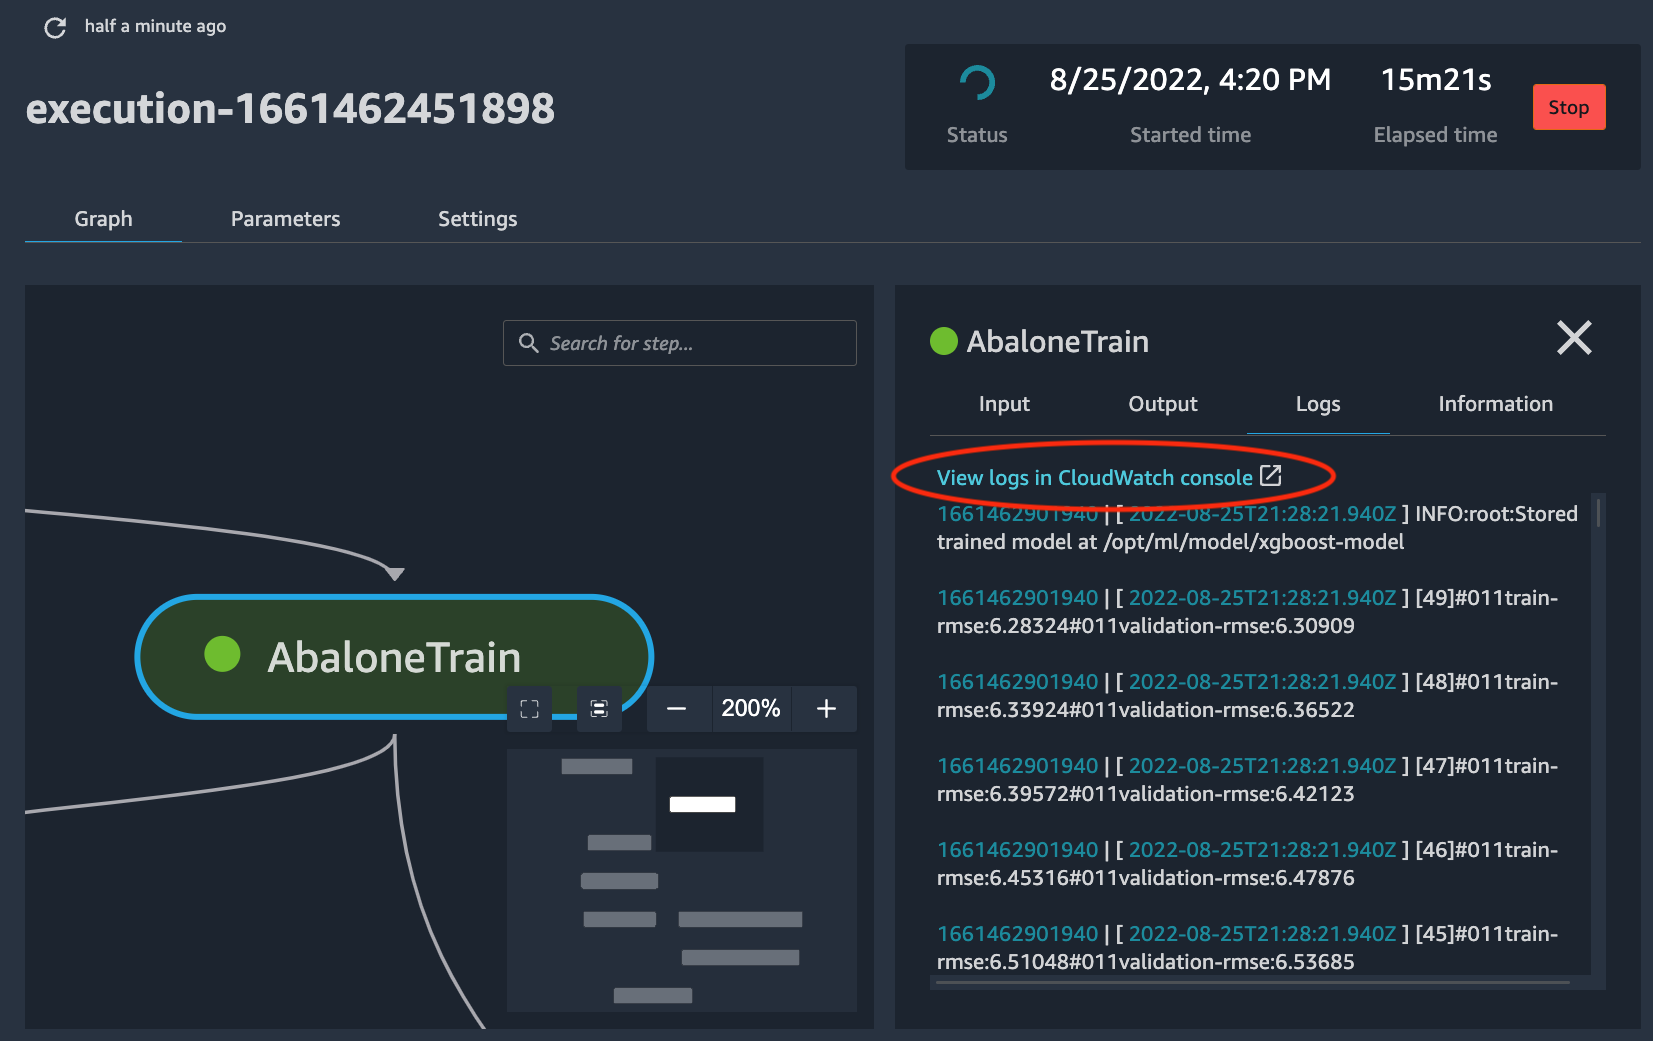